In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, auc, precision_recall_curve, confusion_matrix, roc_curve, f1_score, accuracy_score
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# CSV 파일 불러오기
data = pd.read_csv("../merged_dataset/single_train/single_train.csv")
test_data = pd.read_csv("../extracted_keypoints/jumprope_test/sj_type1_9.csv")

In [3]:
# 'Frame'열을 제외한 모든 열 선택
feature_columns = data.columns[1:-1]

# 입력 데이터(X)와 레이블(Y) 분리
X = data[feature_columns].values
Y = data['Label'].values

X_test = test_data[feature_columns].values
Y_test = test_data['Label'].values



# standardscaler로 데이터 정규화
scaler = StandardScaler()
scaler_test = StandardScaler()


X = scaler.fit_transform(X)
X_test = scaler_test.fit_transform(X_test)


X=X.astype(int)
Y=Y.astype(int)

X_test=X_test.astype(int)
Y_test=Y_test.astype(int)

In [4]:
# train-valid 데이터 분할 (80%, 20%)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
model = RandomForestClassifier()
model.fit(X_train, Y_train)

RandomForestClassifier()

In [6]:
# 모델들 학습 및 평가
model.fit(X, Y)
Y_prob = model.predict_proba(X_test)[:, 1]  
auc_score = roc_auc_score(Y_test, Y_prob)

# 임계값 설정
threshold = 0.5  # 예측된 확률이 0.5 이상이면 클래스를 1로 예측

# 예측된 확률을 클래스 레이블로 변환
Y_pred_binary = (Y_prob >= threshold).astype(int)

# Precision 계산
precision = precision_score(Y_test, Y_pred_binary)

# Recall 계산
recall = recall_score(Y_test, Y_pred_binary)

# F1 score 계산
f1 = f1_score(Y_test, Y_pred_binary)

# Confusion Matrix 계산
conf_matrix = confusion_matrix(Y_test, Y_pred_binary)

accuracy = accuracy_score(Y_test, Y_pred_binary)




In [7]:
# 결과 출력
print("Precision:", precision)
print("Recall:", recall)
print(f"AUC score: {auc_score}")
print("F1 score:", f1)
print("Accuracy:", accuracy)


Precision: 0.7666666666666667
Recall: 0.9857142857142858
AUC score: 0.961156462585034
F1 score: 0.8625
Accuracy: 0.8742857142857143


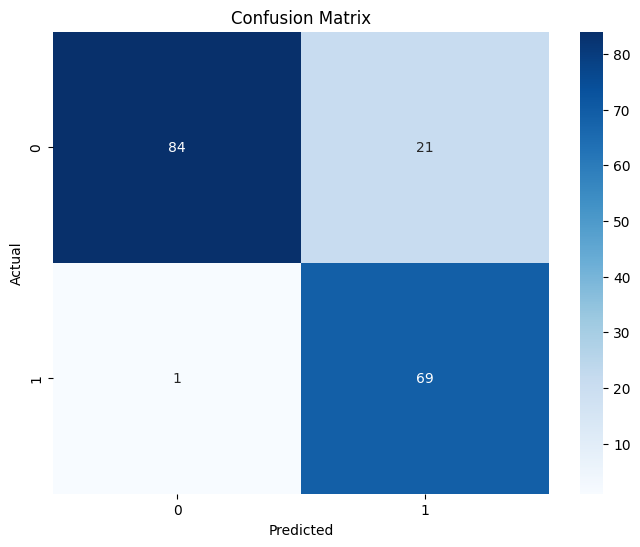

In [8]:
# confusion matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

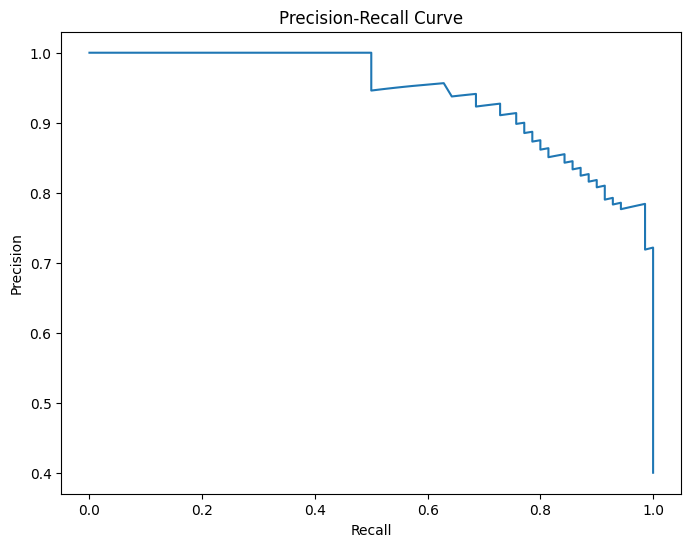

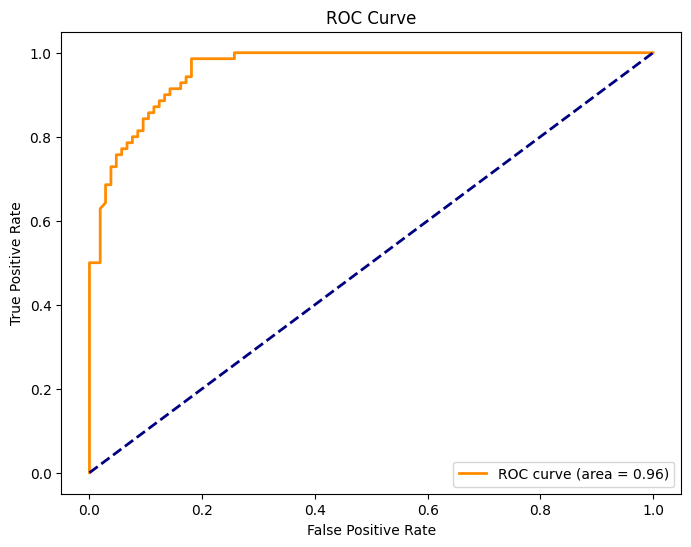

In [9]:
# Precision-Recall curve 그리기
precision, recall, _ = precision_recall_curve(Y_test, Y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC AUC curve 그리기
fpr, tpr, _ = roc_curve(Y_test, Y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
# 테스트 데이터에 대한 예측 결과를 얻기 위해 모델 사용
predictions = model.predict_proba(X_test)[:,1]

# 이동 평균을 계산하여 예측값 부드럽게 만들기
smoothed_predictions = np.convolve(predictions.squeeze(), np.ones(5)/5, mode='same')

# 테스트 데이터에 대한 예측 결과를 바이너리 형태로 변환
binary_predictions = (smoothed_predictions > 0.5).astype(int)

In [11]:
# 0에서 1로 바뀌는 구간에서 줄넘기 개수 카운트
jump_count = np.sum(np.diff(binary_predictions.flatten()) > 0)

In [12]:
# 테스트 데이터의 점프수
print(f'Predicted Jump Count: {jump_count}')


Predicted Jump Count: 10


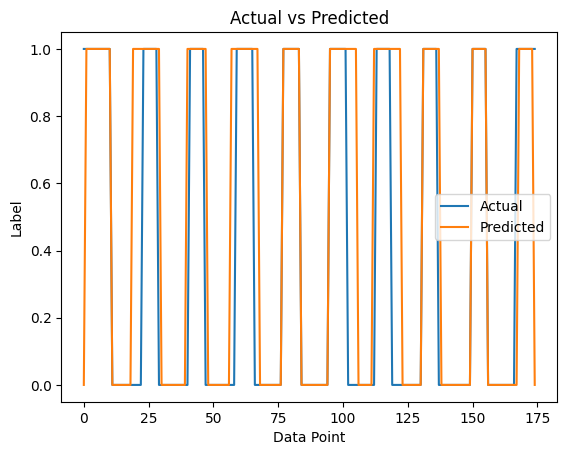

In [13]:
# 테스트 데이터 1에 대한 예측 결과

plt.plot(Y_test, label='Actual')
plt.plot(binary_predictions.flatten(), label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Data Point')
plt.ylabel('Label')
plt.legend()
plt.show()

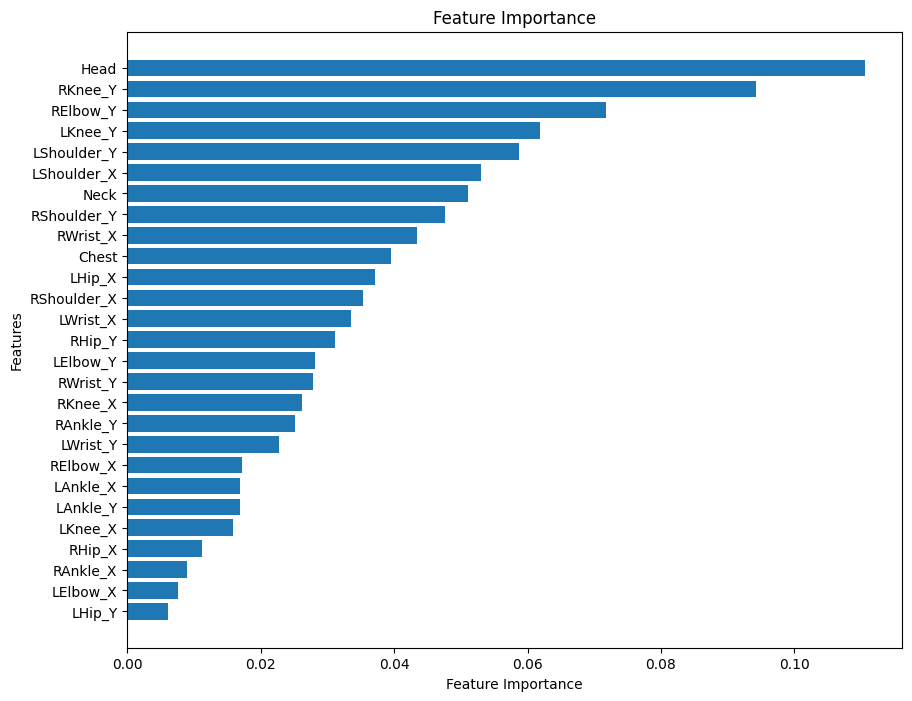

In [14]:
importance = model.feature_importances_

# 중요도를 내림차순으로 정렬한 인덱스
sorted_indices = np.argsort(importance)[::1]

# 정렬된 인덱스를 기반으로 중요도와 특성 이름 추출
sorted_importance = importance[sorted_indices]
sorted_feature_columns = [feature_columns[i] for i in sorted_indices]

# 시각화
plt.figure(figsize=(10, 8))  
plt.barh(range(X.shape[1]), sorted_importance, tick_label=sorted_feature_columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


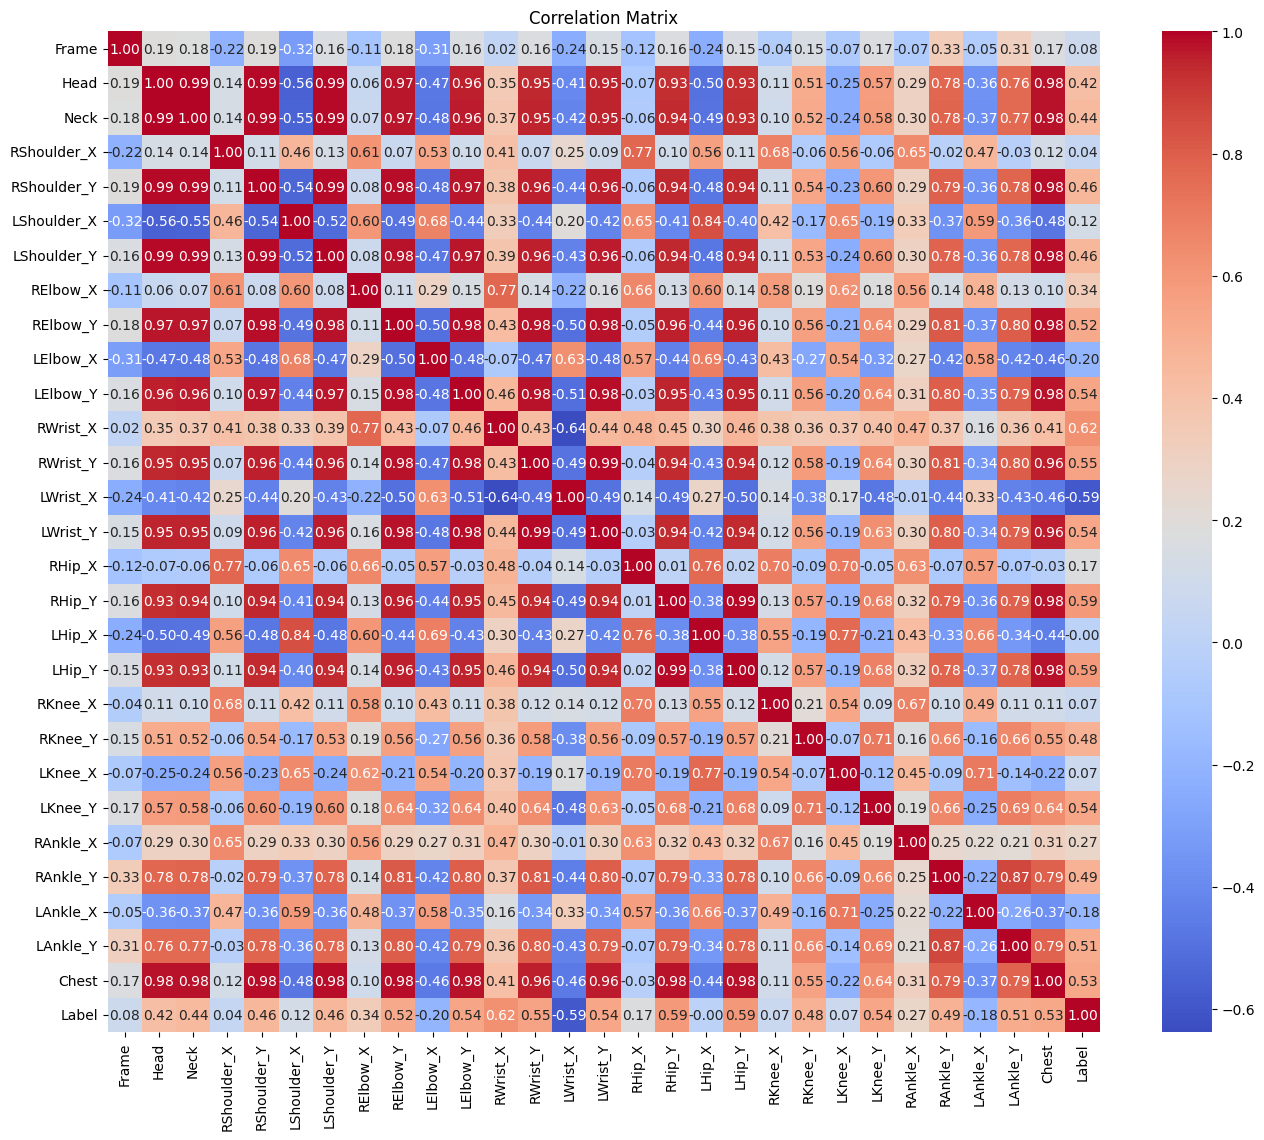

In [15]:
# 상관 행렬 계산
correlation_matrix = data.corr()

# 상관 행렬 시각화
plt.figure(figsize=(16, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()